### **Projet Python pour la data-science : prévision des prix de l'immobilier**

Réalisé par Clémence Chevrier et Soline Mignot

# **1. Import des modules et des bases de données**

# 1.1 Import des modules

In [ ]:
%pip install geopandas
%pip install statsmodels
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
import scipy
from scipy.stats import norm
import pandas as pd

In [ ]:
import warnings

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


# 1.2 Import des bases de données


On importe les données de demande de valeurs foncières géolocalisées depuis le site data.gouv.fr.

In [ ]:
url = 'https://files.data.gouv.fr/geo-dvf/latest/csv/2022/full.csv.gz'
df= pd.read_csv(url, sep=',',low_memory=False)

In [ ]:
df.head()

# **2. Nettoyage de la base de données**

## 2.1 Extraction des colonnes utiles

Nous souhaitons nettoyer la base de données. Pour commencer, nous affichons toutes les colonnes pour pouvoir retirer celles qui nous seront inutiles.

In [ ]:
df.columns

In [ ]:
df=df.drop( columns=['numero_disposition','adresse_numero', 'adresse_suffixe', 'adresse_code_voie', 'code_postal','code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale','id_parcelle', 'ancien_id_parcelle','numero_volume','code_type_local','lot1_numero', 'lot1_surface_carrez', 'lot2_numero','lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez','lot4_numero', 'lot4_surface_carrez', 'lot5_numero','lot5_surface_carrez'], axis=1)

In [ ]:
df.info(null_counts= True)

## 2.2 Modification de la base de données en fonction des variables type_local et nature_mutation

Maintenant, intéressons nous à la variable type_local, qui répertorie si le batîment vendu est une maison, un appartement, une dépendance ou un local industriel. Pour cela, affichons la répartition de cette variable.

In [ ]:
df['type_local'].value_counts(dropna = False, normalize = True).head()

In [ ]:
plt.figure(figsize=(6,6))
labels = ['Données manquantes', 'Maison', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé']
colors = ['#ff6338','#ffd500','#92db1d','#3967db','#37dbd9']
area = [40.6, 16.4, 13.8, 26.1, 3.1]
explode = (0.1,0.1,0.1,0.1,0.1)
plt.pie(area, labels=labels, explode=explode, colors= colors, startangle=60, autopct='%1.1f%%',shadow='True')
plt.title(label= 'Répartition des types de locaux')
plt.legend()
plt.show()

Maintenant, faisons la même chose avec la nature des mutations.

In [ ]:
df['nature_mutation'].value_counts(dropna = False, normalize = True).head()

In [ ]:
plt.figure(figsize=(6,6))
labels = ['Vente', 'Vente en l état futur d achèvement', 'Echange', 'Vente terrain à bâtir','Adjudication']
colors = ['#ff6338','#ffd500','#92db1d','#3967db','#37dbd9']
area = [92.4,6.0,0.9,0.3,0.2]
explode = (0.05,0.05,0.2,0.3,0.4)
plt.pie(area, labels=labels, explode=explode, colors= colors, startangle=65, autopct='%1.1f%%',shadow='True')
plt.title(label= 'Répartition de la nature des mutations')
plt.legend()
plt.show()

Nous remarquons qu'il y a beaucoup de données manquantes (40.6%) pour les types de locaux. Nous décidons donc d'enlever ces données de la base, ainsi que celles correspondant à un local industriel. On souhaite également garder uniquement les données correspondant à une vente, pour ne pas inclure des transactions sur des biens qui n'ont pas encore été construits ou achevés, comme les ventes en l'état futur d'achèvement. En effet, ces transactions peuvent avoir des caractéristiques différentes de celles des biens existants, ce qui peut biaiser l'analyse si elles sont mélangées dans la même étude. On retire donc les données qui ne vont pas nous servir. De plus, nous retirons de la base de données les données dont la surface associée est de 0m² pour pouvoir calculer le prix au mètre carré correctement.

In [ ]:
df=df[df['surface_reelle_bati']!=0]
df=df.loc[df['type_local'].isin(['Maison','Appartement','Dépendance'])]
df=df.loc[df['nature_mutation'].isin(['Vente'])]
df=df.drop_duplicates()
df.dropna(subset=['valeur_fonciere','surface_reelle_bati','nombre_pieces_principales'], inplace=True)

## 2.3 Elimination des valeurs aberrantes par prix du mètre carré

Maintenant, nous souhaitons calculer le prix par mètre carré dans le but d'éliminer les valeurs aberrantes.

In [ ]:
df['prix_au_metre_carre'] = df['valeur_fonciere'] / df['surface_reelle_bati']

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['prix_au_metre_carre'], fill=True, color='skyblue')
plt.xlabel('prix_au_metre_carre')
plt.ylabel('Densité')
plt.title('Densité des Prix au metre carre avant élimination des valeurs aberrantes')
plt.show()

La visibilité sur le prix au mètre carré que procure cette distribution n'est pas très bonne, c'est pourquoi nous allons éliminer les valeurs aberrantes, également appelées outliers. Nous allons nous baser sur l'écart interquartile, IQR, qui est la place entre le premier quartier et le troisième quartile.

In [ ]:
df.columns

In [ ]:
#Description des variables et élimination des valeurs aberrantes
data=df.copy()
data.drop(columns=['id_mutation', 'nature_mutation', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'nombre_lots', 'type_local',
       'longitude', 'latitude'],axis=1).describe(percentiles=[.01,.25, .5, .75, .95, .99]).apply(lambda s: s.apply('{0:.5f}'.format))

In [ ]:
column='prix_au_metre_carre'
Q1=data[column].quantile(0.25)
Q3 = data[column].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df= df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

On voit que cette méthode ne retire pas de valeurs du côté inférieur de la distribution, car la distribution de la colonne 'prix_au_metre_carre' est telle que les valeurs aberrantes se trouvent principalement du côté supérieur de la distribution. Alors, la borne inférieure définie par Q1 - 1.5 * IQR est inférieure à la valeur minimale dans la colonne, n'excluant ainsi aucune valeur dans la partie inférieure.

In [ ]:
df.drop(columns=['id_mutation', 'nature_mutation', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'nombre_lots', 'type_local',
       'longitude', 'latitude'],axis=1).describe(percentiles=[.01,.25, .5, .75, .95, .99]).apply(lambda s: s.apply('{0:.5f}'.format))

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['prix_au_metre_carre'], fill=True, color='skyblue')
plt.xlabel('Prix au metre carre')
plt.ylabel('Densité')
plt.title('Densité des Prix au metre carre après élimination des valeurs aberrantes')
plt.show()

# **3. Statistiques descriptives**


## 3.1 Premières statistiques

Dans la suite de notre projet, nous aurons besoin d'avoir une base de données uniquement dédiée à l'Ile de France. Alors, nous avons décidé d'avoir deux bases de données, une pour l'Ile de France, et une pour toute la France.

### 3.1.1 Statistiques sur la France entière

In [ ]:
df['valeur_fonciere'].describe()

Après avoir éliminé les valeurs aberrantes, on remarque que le prix moyen d'un bien immobilier en France est de 231 105 €, avec un prix maximal de 8 403 500€, ce qui parait plutôt cohérent. Cependant, le prix minimal est de 0.15€, ce qui détonne avec les prix du marché, et peut être dû à un prix symbolique ou à un programme de subvention.

Nous avons aperçu la répartition des prix au mètre carré lorsque nous avons éliminé les valeurs aberrantes plus tôt, mais maintenant, traçons la répartition des valeurs foncières en France.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['valeur_fonciere'], fill=True, color='skyblue')
plt.xlabel('Valeur foncière')
plt.ylabel('Densité')
plt.title('Densité des valeurs foncières')
plt.show()

In [ ]:
quantile_value = np.percentile(df['valeur_fonciere'], 98)
quantile_value

In [ ]:
len(df.loc[df['valeur_fonciere']<400000])/len(df) * 100

On observe avec les calculs ci-dessus, que 87.5% des biens ont un prix inférieur à 400 000€ et que seuls 2% o,t un prix supérieur à 750 000€. Nous allons donc tracer les distributions de prix selon ces seuils.

In [ ]:
warnings.simplefilter('ignore')

fig, axs = plt.subplots(ncols=3, figsize=(20, 7))

ax0 = sns.distplot(df[df['valeur_fonciere'] <= 400000]['valeur_fonciere'], ax=axs[0])
ax0.set_title('Distribution des prix inférieurs à 400 000 euros')

ax1 = sns.distplot(df[(df['valeur_fonciere'] > 400000) & (df['valeur_fonciere'] <= 750000)]['valeur_fonciere'], ax=axs[1])
ax1.set_title('Distribution des prix entre 400 000 euros et 750000 euros')

ax2 = sns.distplot(df[df['valeur_fonciere'] > 750000]['valeur_fonciere'], ax=axs[2])
ax2.set_title('Distribution des prix supérieurs à 750 000 euros')


On remarque que peu importe comment on décide de considérer la partie très supérieure, ici celle dans les 2%, il y a toujours des biens dont le prix est beaucoup plus élevé, atteignant 8 millions d'euros.

Nous souhaitons alors savoir ce qui influence le plus le prix d'un bien immobilier. Nous avons pensé à des facteurs tels que : la superficie du bien, le nombre de chambres, sa localisation, sa proximité à des stations de métro, sa proximité à des espaces verts...

### 3.1.1.1 Modélisation d'une carte de France selon le prix du mètre carré

Nous avons donc premièrement décidé de modéliser une carte de France selon le prix médian au mètre carré, pour avoir un aperçu de la répartition des biens.

Nous souhaitons maintenant afficher le prix du mètre carré en fonction du département. Pour cela, nous allons réaliser une médiane par département, et l'afficher sur une carte de France. En effet, la médiane permet d'être plus proche de la réalité car elle est moins affectée par les valeurs extrêmes.

In [ ]:
#On importe des données sur les départements
france = gpd.read_file('/content/drive/MyDrive/2A_Python pour la data science/departements-version-simplifiee.geojson')
france.head(5)

In [ ]:
#On nettoie les données pour garder uniquement le code du département, la surface réelle du batiment et sa valeur foncière
df_carte = df[['code_departement', 'surface_reelle_bati', 'valeur_fonciere','prix_au_metre_carre']]

In [ ]:
#On retire les NaN
df_carte = df_carte.dropna()

In [ ]:
print(df_carte.dtypes)
#On s'aperçoit que la valeur foncière n'est pas un float, et que le prix est avec une virgule, donc on va remplacer cette virgule par un point puis convertir en float

In [ ]:
#df_carte['Valeur fonciere'] = pd.to_numeric(df_carte['Valeur fonciere'].str.replace(',', '.'), errors='coerce')


In [ ]:
#On calcule la médiane par département
mediane_par_departement = df_carte.groupby('code_departement')['prix_au_metre_carre'].median().reset_index()

In [ ]:
#On joint les données des deux dataframe sur le code département
merged_data = france.merge(mediane_par_departement, how='left', left_on='code', right_on='code_departement')

In [ ]:
merged_data.head(5)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='prix_au_metre_carre', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Médiane du mètre carré par département en France (2022)')
ax.set_axis_off()
plt.show()

Nous avons donc vu qu'il y a un lien important entre la localisation de l'habitation et son prix. Plus particulièrement, nous observons que la région Ile de France semble être beaucoup plus chère. C'est pourquoi, nous avons décidé de réaliser d'autres statistiques sur l'Ile de France uniquement.


Maintenant, nous souhaitons savoir si, à plus petite échelle, celle d'une ville, la proximité de certains établissements influe sur le prix de l'immobilier.

## 3.1.2 Statistiques sur l'Ile de France

On restreint le data frame à l'Ile de France.

In [ ]:
departements_idf = ['75', '77', '78', '91', '92', '93', '94', '95']
df_idf = df[df['code_departement'].astype(str).isin(departements_idf)]


In [ ]:
df_idf['valeur_fonciere'].describe()

In [ ]:
df_idf['prix_au_metre_carre'].describe()

In [ ]:
df['prix_au_metre_carre'].describe()

On remarque que le prix moyen d'un bien immobilier en Ile de France est de 315 061€, contre 231 105 € pour la moyenne française, soit presque 85 000€ d'écart. On pourrait croire à une différence dans la superficie des biens, mais c'est bien le prix au mètre carré qui diffère totalement, avec une moyenne de 4328€/m² en Ile de France et 2873€/m² sur la France entière.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_idf['valeur_fonciere'], fill=True, color='skyblue')
plt.xlabel('Valeur foncière')
plt.ylabel('Densité')
plt.title('Densité des valeurs foncières en Ile de France')
plt.show()

In [ ]:
len(df_idf.loc[df_idf['valeur_fonciere']<510000])/len(df_idf) * 100

On remarque que cette fois-ci, le seuil défini plus haut (de 87.5%) est atteint avec une valeur_fonciere de 510 000€, soit 110 000€ de plus que dans la France entière.

Ainsi, avec ces premières statistiques, nous savons que la localisation est un facteur corrélé avec la valeur foncière d'un bien.

#**4. Corrélation entre les variables**

##4.1 Variables quantitatives

La base de données sur les valeurs foncières est composée des variables suivantes. Nous souhaiterions avoir davantage de variables quantitatives pour pouvoir trouver des corrélations numériques. Pour cela, nous devons transformer le type de certaines variables et également en créer d'autres.

In [ ]:
df.dtypes

In [ ]:
df['code_departement'].unique()

Pour commencer, il s'agit de transformer le code_departement en un entier pour qu'il soit une variable quantitative. Cependant, nous rencontrons un problème avec la Corse et ses départements 2A et 2B. Nous décidons alors de les retirer du data frame, ainsi que les départements d'outre mer, car ils ne représentent que 19 000 données sur plus d'un million.

In [ ]:
count_departments = df['code_departement'].isin(['971', '972', '973', '974','2A','2B']).sum()
count_total = len(df)
print(count_departments, count_total)

In [ ]:
df = df[~df['code_departement'].isin(['971', '972', '973', '974','2A','2B'])]
df['code_departement'] = df['code_departement'].astype(int)
df['code_commune'] = df['code_commune'].astype(int)

Ensuite, on ajoute le mois de vente à partir de la colonne date_mutation pour ensuite voir si elle a un impact sur la valeur foncière.

In [ ]:
df['mois_vente'] = df['date_mutation'].str[-2:]
df['mois_vente'] = df['mois_vente'].astype(int)

Ensuite, on ne garde que les variables quantitatives.

In [ ]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num = df_num.drop('ancien_code_commune', axis=1)
df_num.head()

In [ ]:
sns.set_theme(style="white")

corr = df_num.corr()

# Génération d'un masque pour la partie supérieure du triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Création d'une palette de couleurs
cmap = sns.color_palette("vlag", as_cmap=True)

# Tracé de la heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Cherchons les variables numériques les plus corrélées au prix et classons-les. Les variables les plus corrélées au prix sont alors le prix au mètre carré, la surface réelle du batiment ainsi que le nombre de pièces.

In [ ]:
var_quanti_corr = df_num.corr()['valeur_fonciere']
var_plus_corr = var_quanti_corr.sort_values(ascending=False)
print(var_plus_corr)

##4.2 Variables qualitatives

###4.2.1 La variable type_local

Nous souhaitons également connaitre la corrélation entre la valeur foncière d'un bien et certaines variables qualitatives, comme le type de bien (Appartement, Maison). Pour ce faire, nous avons utilisé la corrélaion de Spearman, qui permet d'évaluer la relation monotone entre deux variables, l'une quantitative et l'autre qualitative, ici valeur_fonciere et type_local. Elle donne une mesure de la force et de la direction de la relation entre les deux variables. Ici, le coefficient de corrélation est 0.17 et est positif, ce qui suggère qu'une augmentation de la valeur foncière est conjointement lié à une augmentation du type de local, d'appartement vers maison.

In [ ]:
from scipy.stats import spearmanr

# Calcul de la corrélation de Spearman
correlation_coefficient, p_value = spearmanr(df['valeur_fonciere'], df['type_local'])
print(f"Corrélation de Spearman : {correlation_coefficient}")
print(f"P-valeur : {p_value}")

In [ ]:
valeurs_non_numeriques = pd.to_numeric(df['valeur_fonciere'], errors='coerce').isnull()
df[valeurs_non_numeriques]['valeur_fonciere']

De plus, nous effectuons un t test pour comparer les moyennes des deux groupes, Maison et Appartement.  

In [ ]:
from scipy.stats import ttest_ind

# Sélectionner les données pour 'Maison' et 'Appartement'
maison = df[df['type_local'] == 'Maison']['valeur_fonciere']
appartement = df[df['type_local'] == 'Appartement']['valeur_fonciere']

# Test t indépendant pour comparer les moyennes
t_statistic, p_value_t = ttest_ind(maison, appartement)

print(f"Test t - Statistique t : {t_statistic}, p-valeur : {p_value_t}")

La t-statistique mesure la différence entre les moyennes des deux groupes standardisée par l'erreur standard. Alors, une valeur de 186 indique une différence très importante entre les moyennes. De plus, la p-valeur est la probabilité d'observer une statistique t aussi extrême (ou plus) si l'hypothèse nulle était vraie (c'est-à-dire si les moyennes réelles des groupes étaient égales). La p-valeur étant de 0, et donc inférieure à 0.05, cela signifie que la probabilité d'observer une telle différence par hasard est pratiquement nulle.



**Pour conclure, ces résultats suggèrent fortement que les moyennes des groupes "Maison" et "Appartement" sont significativement différentes l'une de l'autre pour la variable valeur_fonciere.**

###4.2.2 La variable type_voie

Nous ne disposons pas directement du type de voie dans lequel le bien immobilier se situe, c'est pourquoi nous allons devoir extraire cette information des autres colonnes.

In [ ]:
df.head()

Pour cela, nous prenons le premier mot de la colonne adresse_nom_voie et on ne garde que les lignes qui correspondent à des rues, avenues, boulevards, chemins, routes, places, allées ou impasses. Les autres types sont souvent des lieux dits, sans adresse précise. En réduisant ce dataframe, on reste tout de même à presque un million de données.

In [ ]:
df['type_voie'] = df['adresse_nom_voie'].str.split().str[0]

In [ ]:
df_voie = df[df['type_voie'].isin(['RUE', 'AV', 'BD', 'CHE', 'RTE', 'PL', 'ALL', 'IMP'])]

In [ ]:
df_voie.shape[0]

On renomme les types de voies.

In [ ]:
mapping_types_voie = {'RUE': 'Rue', 'RTE': 'Route', 'PL': 'Place', 'AV': 'Avenue', 'BD': 'Boulevard', 'CHE': 'Chemin', 'ALL': 'Allée', 'IMP': 'Impasse'}
df_voie['type_voie'] = df_voie['type_voie'].replace(mapping_types_voie)

In [ ]:
df_voie.head()

Simplement avec ces boîtes à moustaches, on peut constater que les médianes des valeurs foncières entre les différents types de voies diffèrent très largement. Cependant, nous souhaitons en extraire un coefficient de corrélation pour savoir si le type de voie est corrélé au prix.

In [ ]:
# Création de boxplots pour chaque catégorie de type_voie
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='type_voie', y='valeur_fonciere', data=df_voie)

# Annotation des boîtes avec les médianes
medians = df_voie.groupby('type_voie')['valeur_fonciere'].median()
medians_dict = medians.to_dict()

for cat, median_value in medians_dict.items():
    ax.text(list(medians.index).index(cat),
            median_value + ax.get_ylim()[1]*0.02,  # Ajuster la position verticale
            f'{median_value:.2f}',
            ha='center', va='bottom', color='black', fontsize=9)

# Ajout d'un texte supplémentaire
ax.text(1, -0.15, 'Les annotations représentent les médianes', ha='right', va='bottom', color='black', fontsize=12, transform=ax.transAxes)

plt.title('Distribution de la valeur_fonciere par type_voie', fontsize=14)  # Ajuster la taille du titre
plt.show()

Nous nous sommes heurtés à de nombreux problème quant au coefficient de corrélation entre les variables valeur_fonciere, quantitative, et type_voie, elle qualitative, car contrairement à type_local, la variable n'est pas binaire et comporte 8 niveaux. Après avoir étudié les méthodes ANOVA juste en dessous, qui ne testait que la variation des moyennes entre plusieurs groupes, nous nous sommes penchés sur l'Analyse de Corrélation Canonique (CCA), qui nous a permis de tirer un coefficient de corrélation. En effet, la CCA est une méthode puissante pour évaluer les relations linéaires complexes entre des ensembles de variables multiples.

ANOVA (Analysis of Variance) : permet de comparer les moyennes de trois groupes ou plus afin de déterminer s'il existe des différences significatives entre eux

In [ ]:
from scipy.stats import f_oneway

# Supposons que df_voie contient vos données
resultats_anova = f_oneway(*[df_voie['valeur_fonciere'][df_voie['type_voie'] == cat] for cat in df_voie['type_voie'].unique()])

# Afficher le résultat
print("Statistique F :", resultats_anova.statistic)
print("P-valeur :", resultats_anova.pvalue)

La statistique F étant de 4189, cela indique une grande variation entre les groupes par rapport à la variation à l'intérieur des groupes. La p-value de 0 suggère qu'il faut rejeter l'hypothèses nulle et ainsi, les moyennes des groupes ne sont pas égales. Cependant, cela ne nous donne pas le coefficient de corrélation. Passons donc à la méthode CCA. On crée un dataframe one_hot_encoded où chaque catégorie unique présente dans la colonne "type_voie" devient une nouvelle colonne binaire. Chaque colonne binaire indique la présence ou l'absence de la catégorie respective pour chaque ligne du dataframe original.

In [ ]:
from sklearn.cross_decomposition import CCA

# On convertit la colonne en un type de données catégorielles (qualitatives)
df_voie['type_voie'] = df_voie['type_voie'].astype('category')

# Création d'un encodage one-hot pour la variable qualitative
one_hot_encoded = pd.get_dummies(df_voie['type_voie'], prefix='voie')

# Concaténation des données
df_combined = pd.concat([df_voie['valeur_fonciere'], one_hot_encoded], axis=1)

# Séparation les variables indépendantes et dépendantes
X = df_combined.drop('valeur_fonciere', axis=1)
y = df_combined['valeur_fonciere']

# Analyse de corrélation canonique (CCA)
cca = CCA(n_components=1)
cca.fit(X, y)

# Transformations des données et obtention des composantes canoniques
cca_transformed = cca.transform(X, y) # Contient les projections des données dans l'espace des composantes canoniques
cca_coefficients = cca_transformed[0] # Première composante canonique, car on a choisi "n_components=1"

# Affichage du résultat
print("Coefficient de corrélation canonique:", cca_coefficients[0][0])

La première composante canonique est une nouvelle variable (ou axe) qui est créée à partir des variables originales de manière à capturer le maximum de la corrélation entre les deux ensembles X et Y. Cette composante canonique est une expression mathématique définie par des coefficients (poids) attribués à chaque variable dans les ensembles X et Y.Ainsi, -0,61 indique la force et la direction de la corrélation maximale entre la première composante canonique et valeur_fonciere.

In [ ]:
df_combined.head()

Alors, lorsqu'on observe une transition d'une catégorie à une autre dans la variable catégorielle "type_voie", on s'attend à une variation dans les valeurs de "valeur_fonciere" en fonction du coefficient de corrélation canonique.

In [ ]:
df_voie = df_voie.dropna(subset=['type_voie', 'valeur_fonciere'])

# **5. Réduction de l'analyse à Paris pour l'ajout de variables explicatives**

##5.1 Ajout de la variable de distance à une station de métro ou RER

On s'intéresse maintenant à Paris intramuros pour essayer de prédire les prix. Pour cela, nous choisissons de voir si la proximité d'une station de métro ou RER est liée à la valeur foncière. Pour cela, nous importons les données des gares depuis data.gouv.fr et nous en créons un dataframe.

In [ ]:
# Emplacement des gares en Ile-de-France
path = '/content/drive/MyDrive/2A_Python pour la data science/'
df_stations= pd.read_csv(path+'emplacement-des-gares-idf.csv', sep=';',low_memory=False)
df_stations.head(5)

In [ ]:
df_stations=df_stations.drop(['id_gares','nom_so_gar',
       'nom_su_gar','id_ref_zdc','nom_zdc', 'id_ref_zda', 'nom_zda','idrefliga', 'idrefligc','tertrain',
       'terrer', 'termetro', 'tertram', 'terval', 'exploitant','idf',
       'principal','picto', 'nom_iv','x','y'],axis=1)

In [ ]:
df_idf

On veut calculer la distance à la gare la plus proche en Ile de France, donc on retire les lignes qui ont une latitude ou une longitude manquante.

In [ ]:
df_idf = df_idf.dropna(subset=['latitude', 'longitude'])
df_stations = df_stations.dropna(subset=['geo_point_2d'])

Calculons la distance à la gare la plus proche. Vu le nombre de calcul à faire pour pouvoir avoir ces distances, le programme prend 1h20. Ce n'est pas un calcul que l'on va donc refaire à chaque fois. Par conséquent, on va sauvergarder ces informations sur un fichier annexe duquel on puisera l'information à chaque fois.

In [ ]:

#def find_nearest_station(apartment, stations_df):
#    apartment_coords = (apartment['latitude'], apartment['longitude'])
#    distances = stations_df.apply(lambda row: geodesic(apartment_coords, row['geo_point_2d']).meters, axis=1)
#    nearest_station_index = distances.idxmin()
#    nearest_station = stations_df.loc[nearest_station_index, 'nom_gares']
#    return (nearest_station,distances[nearest_station_index])
#df_idf['nearest_station'] = df_idf.apply(lambda row: find_nearest_station(row,stations_echantillonneesdf_stations),axis=1)
#df_idf[['nom_station','distance_station_plus_proche']]=df_idf['nearest_station'].apply(lambda x: pd.Series(x))
#df_idf.head()df_gares_proches=df_idf.drop(columns=[ 'date_mutation', 'numero_disposition', 'nature_mutation','valeur_fonciere', 'adresse_numero', 'adresse_suffixe','adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune','nom_commune', 'code_departement', 'ancien_code_commune','ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle','numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero','lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez','lot4_numero', 'lot4_surface_carrez', 'lot5_numero','lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local','surface_reelle_bati', 'nombre_pieces_principales','code_nature_culture', 'nature_culture', 'code_nature_culture_speciale','nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude','prix_au_metre_carre', 'nearest_station', ],axis=1)
#df_gares_proches.to_csv('/content/drive/MyDrive/2A_Python pour la data science/stations_les_plus_proches.txt',index=False)

Maintenant, on va faire un code pour récupérer cette information beaucoup plus rapidement, grâce au fichier.

In [ ]:
#path = '/content/drive/MyDrive/2A_Python pour la data science/'
#df_gares_proches= pd.read_csv(path+'stations_les_plus_proches.txt', sep=',',low_memory=False)
#df_idf=pd.merge(df_idf,df_gares_proches, on='id_mutation', how='inner')
#df_idf=df_idf.drop_duplicates()
#df_idf.head(5)

On réduit ce data frame à Paris ce qui nous donne 6668 données.

In [ ]:
df_paris = df_idf[df_idf['code_departement'] == '75']
df_paris

On crée une colonne avec l'arrondissement et on retire d'autres colonnes inutiles.

In [ ]:
df_paris['arrondissement'] = df_paris['code_commune'].astype(str).str[-2:]

In [ ]:
df_paris = df_paris.drop(columns=["ancien_code_commune", "ancien_nom_commune", "surface_terrain"], errors='ignore')

In [ ]:
df_paris.head(5)

In [ ]:
#distance à la gare la plus proche (que paris)

#def find_nearest_station(apartment, stations_df):
#    apartment_coords = (apartment['latitude'], apartment['longitude'])
#    distances = stations_df.apply(lambda row: geodesic(apartment_coords, row['geo_point_2d']).meters, axis=1)
#    nearest_station_index = distances.idxmin()
#    nearest_station = stations_df.loc[nearest_station_index, 'nom_gares']
#    return (nearest_station,distances[nearest_station_index])
#df_paris['nearest_station'] = df_paris.apply(lambda row: find_nearest_station(row,df_stations),axis=1)
#df_paris[['nom_station','distance_station_plus_proche']]=df_paris['nearest_station'].apply(lambda x: pd.Series(x))
#df_paris.head()

#df_gares_proches_paris=df_paris.drop(columns=[ 'date_mutation', 'nature_mutation', 'valeur_fonciere','adresse_nom_voie', 'code_commune', 'nom_commune', 'code_departement','ancien_code_commune', 'ancien_nom_commune', 'nombre_lots','type_local', 'surface_reelle_bati', 'nombre_pieces_principales','surface_terrain', 'longitude', 'latitude', 'prix_au_metre_carre','nearest_station',],axis=1)
#df_gares_proches_paris.to_csv('/content/drive/MyDrive/2A_Python pour la data science/stations_les_plus_proches.txt',index=False)

In [ ]:
path = '/content/drive/MyDrive/2A_Python pour la data science/'
df_gares_proches= pd.read_csv(path+'stations_les_plus_proches.txt', sep=',',low_memory=False)
df_paris=pd.merge(df_paris,df_gares_proches, on='id_mutation', how='inner')
df_paris=df_paris.drop_duplicates()
df_paris.head(5)

On a donc rajouté une variable explicative : la distance à la gare la plus proche.

##5.2 Ajout de la distance à un espace vert

On a voulu se restreindre à Paris dans cette partie car nous ne possédons que les espaces verts de Paris. On importe les données depuis data.gouv.fr et on garde uniquement les espaces verts de tailles conséquente, c'est à dire les promenades et les bois.

In [ ]:
df_espaces_verts=pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/df83af76-2045-4b3e-8a94-b7cced0d0b69',sep=';',low_memory=False)
df_espaces_verts=df_espaces_verts.drop(['nsq_espace_vert',
       'surface_horticole', 'presence_cloture', 'perimeter', 'annee_ouverture',
       'annee_renovation', 'ancien_nom_ev', 'annee_changement_nom',
       'nb_entites', 'ouvert_ferme',  'id_atelier_horticole','geom_x_y','competence','id_eqpt','site_villes','ida3d_enb',
       ],axis=1)
df_espaces_verts['type_ev'].unique()

In [ ]:
df_espaces_verts=df_espaces_verts[df_espaces_verts['type_ev'].isin(['Promenades ouvertes', 'Bois'])]

plt.figure(figsize=(10, 6))
sns.kdeplot(df_espaces_verts['surface_totale_reelle'], fill=True, color='skyblue')
plt.xlabel('surface totale des espaces verts')
plt.ylabel('Densité')
plt.title('Surfaces des espaces verts avant élimination des valeurs aberrantes')
plt.show()

df_espaces_verts=df_espaces_verts[df_espaces_verts['surface_totale_reelle']>=130]


In [ ]:
df_espaces_verts=df_espaces_verts[df_espaces_verts['type_ev'].isin(['Promenades ouvertes', 'Bois'])]

df_espaces_verts=df_espaces_verts[df_espaces_verts['surface_totale_reelle']>=130]
df_espaces_verts['surface_totale_reelle'].describe()

In [ ]:
df_espaces_verts.head()
df_espaces_verts['categorie'].unique()

In [ ]:
df_espaces_verts.nsmallest(5, 'poly_area')

Malgré notre premier tri sur les promenades et bois, il reste des espaces verts trop petits pour en être. On décide donc de retirer les espaces verts qui ne font pas plus de 130m².

In [ ]:
df_espaces_verts = df_espaces_verts.loc[df_espaces_verts['surface_totale_reelle'] > 130]


Pour commencer, nous décidons d'afficher une carte pour voir si la répartition des espaces verts est équilibrée ou pas. Pour cela, on importe un geojson sur les arrondissements et on affiche une carte avec le nombre d'espaces verts par arrondissement.

In [ ]:
url_arrondissements='https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c'
arrondissements_geojson=gpd.read_file(url_arrondissements)

In [ ]:
df_espaces_verts['adresse_codepostal'] = df_espaces_verts['adresse_codepostal'].astype(int)
df_espaces_verts['arrondissement'] = df_espaces_verts['adresse_codepostal'].apply(lambda x: int(str(x)[2:]))

df_grouped = df_espaces_verts.groupby('arrondissement').size().reset_index(name='nombre_espaces_verts')
new_df_merged = arrondissements_geojson.merge(df_grouped, left_on='c_ar', right_on='arrondissement')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_df_merged.plot(column='nombre_espaces_verts', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Nombre d\'espaces verts par arrondissement à Paris')
plt.show()

Alors, on voit que les espaces verts sont principalement situés dans les arrondissements extérieurs. Maintenant que nous savons que ce n'est pas forcément inintéressant, calculons la distance de chaque bien à l'espace vert le plus proche dans Paris.

In [ ]:
import json
df_espaces_verts= df_espaces_verts.dropna(subset=['geom'])
df_espaces_verts['geom']=df_espaces_verts['geom'].astype(str)
df_espaces_verts['geom'] = df_espaces_verts['geom'].apply(json.loads)
df_espaces_verts['geom'] = df_espaces_verts['geom'].apply(lambda x: x['coordinates'])
df_espaces_verts.head(5)

In [ ]:
df_espaces_verts.head(5)

In [ ]:
def extract_first_element(coord_list):
    texte=str(coord_list)
    i=0
    while texte[i]=='[':
      i+=1
    liste=coord_list
    for i in range (i-1):
      liste=liste[0]
    return liste[0],liste[1]

df_espaces_verts['first_coordinate'] = df_espaces_verts['geom'].apply(extract_first_element)

In [ ]:
df_paris

In [ ]:
df_paris.head(1)

In [ ]:
#def find_nearest_green(apartment, parcs_df):
#    apartment_coords = (apartment['longitude'], apartment['latitude'])
#    distances = parcs_df.apply(lambda row: geodesic(apartment_coords, row['first_coordinate']).meters, axis=1)
#    nearest_parc_index = distances.idxmin()
#    nearest_parc = parcs_df.loc[nearest_parc_index, 'nom_ev']
#    return (nearest_parc,distances[nearest_parc_index])
#df_paris['nearest_parc'] = df_paris.apply(lambda row: find_nearest_green(row,df_espaces_verts),axis=1)
#df_paris[['nom_ev','distance_parc_plus_proche']]=df_paris['nearest_parc'].apply(lambda x: pd.Series(x))


In [ ]:
#df_ev_proches=df_paris.drop(columns=['date_mutation', 'nature_mutation', 'valeur_fonciere','adresse_nom_voie', 'code_commune', 'nom_commune', 'code_departement','nombre_lots', 'type_local', 'surface_reelle_bati','nombre_pieces_principales', 'longitude', 'latitude','prix_au_metre_carre', 'arrondissement', 'nom_station','distance_station_plus_proche', 'nearest_parc'],axis=1)

In [ ]:
#df_ev_proches.to_csv('/content/drive/MyDrive/2A_Python pour la data science/df_paris_espaces_verts_les_plus_proches.txt',index=False)

In [ ]:
path = '/content/drive/MyDrive/2A_Python pour la data science/'
df_ev_proches= pd.read_csv(path+'df_paris_espaces_verts_les_plus_proches.txt', sep=',',low_memory=False)

In [ ]:
df_ev_proches

In [ ]:
df_ev_proches.head()

In [ ]:
df_paris=pd.merge(df_paris,df_ev_proches, on='id_mutation', how='inner')
df_paris=df_paris.drop_duplicates()

In [ ]:
df_paris.head()

##5.3 Ajout de la satisfaction dans l'arrondissement

Nous avons décidé d'ajouter la satisfaction des riverains à vivre dans un arrondissement. Ainsi, nous récupérons les données du site ParisSecret qui recense l'avis des habitants sous la forme d'une note selon 9 caractéristiques : culture, transports, environnement, sécurité, santé...

In [ ]:
data = {
    'Arrondissement': [
        '03', '05', '08', '12', '06', '16', '15', '09', '07',
        '17', '11', '01', '13', '20', '19', '14', '02',
        '04', '18', '10'
    ],
    'note': [
        8.25, 8.03, 7.6, 7.56, 7.54, 7.5, 7.41, 7.38, 7.31, 7.17,
        6.9, 6.58, 6.57, 6.32, 6.21, 6.15, 6.06, 5.89, 5.12, 4.94
    ]
}

df_note_arr = pd.DataFrame(data)

In [ ]:
df_note_arr

In [ ]:
df_paris = pd.merge(df_paris, df_note_arr, left_on='arrondissement', right_on='Arrondissement', how='left')
df_paris.drop('Arrondissement', axis=1, inplace=True)

In [ ]:
df_paris

On a donc encore rajouté une variable explicative.

##5.4 Ajout de la variable prix moyen du mètre carré dans l'arrondissement

Nous avons décidé d'ajouter comme variable le prix moyen du mètre carré dans l'arrondissement. Pour cela, nous extrayons les données du site immobilier.lefigaro.

In [ ]:
data_prix_moyen_m2 = {
    'Arrondissement': ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
  ,
    'prix_moy_m2_arr': [11432,12071,12688,13606,12921,15433,15407,12962,11510,10045,10669,9954,9509,10469,10526,11922,11000,9613,8852,9464]
}

df_prix_moy_arr = pd.DataFrame(data_prix_moyen_m2)

In [ ]:
df_paris = pd.merge(df_paris, df_prix_moy_arr.set_index('Arrondissement'),
                    left_on='arrondissement', right_index=True, how='left').reset_index()

In [ ]:
df_paris

Nous avons encore rajouté une variable explicative.

##5.5 Matrice de corrélation dans Paris avec les variables ajoutées

On ajoute la variable d'appartement ou maison sous la forme d'une variable quantitative puisqu'elle est binaire.

In [ ]:
df_paris['mois_vente'] = df_paris['date_mutation'].str[-2:]
df_paris['mois_vente'] = df_paris['mois_vente'].astype(int)
df_paris['indicatrice_maison'] = df_paris['type_local'].apply(lambda x: 1 if x == 'Maison' else 0)

In [ ]:
df_paris.drop('index', axis=1, inplace=True)

In [ ]:
df_paris_num = df_paris.select_dtypes(include = ['float64', 'int64'])

<Axes: >

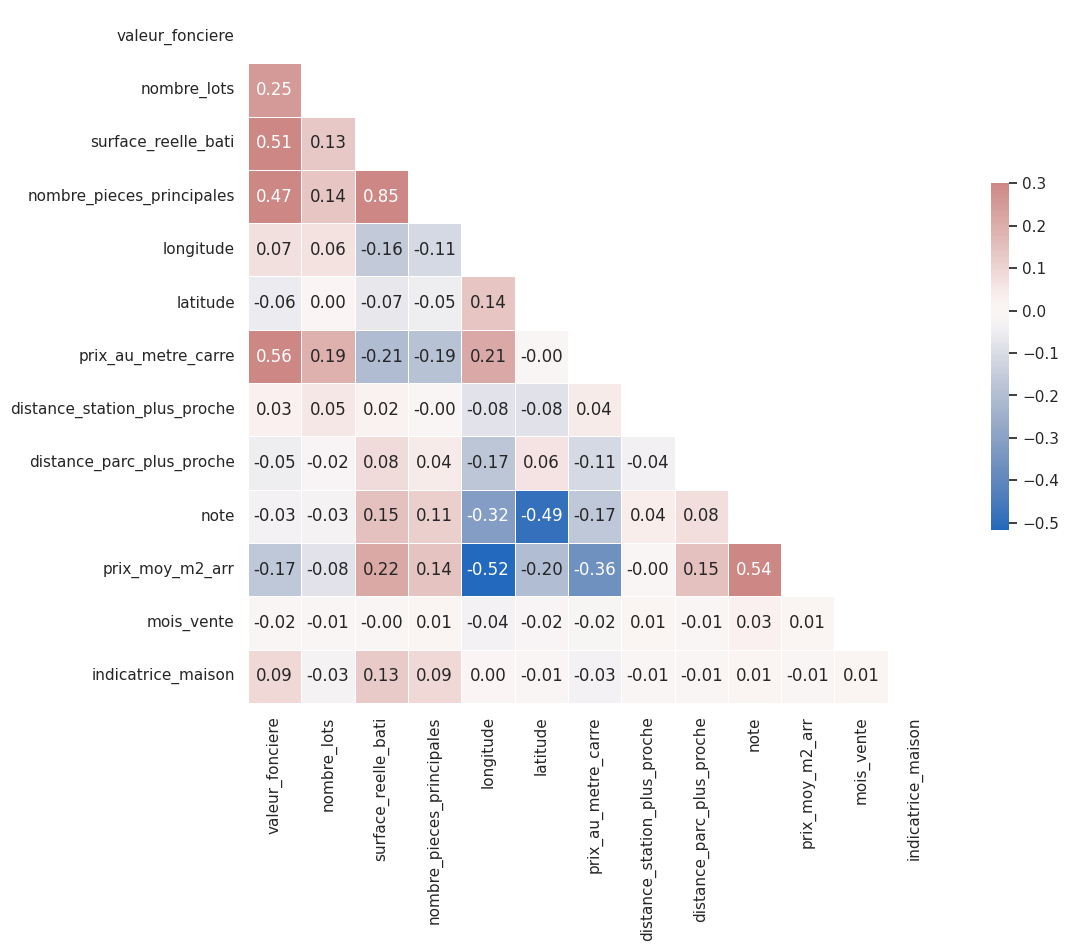

In [ ]:
sns.set_theme(style="white")

corr_paris = df_paris_num.corr()

# Génération d'un masque pour la partie supérieure du triangle
mask = np.triu(np.ones_like(corr_paris, dtype=bool))
f, ax = plt.subplots(figsize=(13, 9))

# Création d'une palette de couleurs
cmap = sns.color_palette("vlag", as_cmap=True)

# Tracé de la heatmap
sns.heatmap(corr_paris, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

#**6. Modélisation sur Paris**

## 6.1 Préparation du dataset

Nous voulons nous assurer que notre dataset ne comporte aucune valeur manquante dans les colonnes essentielles. C'est bien le cas avec le travail réalisé avant. Effectivement, étant donné l'unicité de chaque bien, il n'était pas possible de substituer certaines valeurs par une moyenne ou une médiane.

In [ ]:
df_paris.isnull().sum()

id_mutation                     0
date_mutation                   0
nature_mutation                 0
valeur_fonciere                 0
adresse_nom_voie                0
code_commune                    0
nom_commune                     0
code_departement                0
nombre_lots                     0
type_local                      0
surface_reelle_bati             0
nombre_pieces_principales       0
longitude                       0
latitude                        0
prix_au_metre_carre             0
arrondissement                  0
nom_station                     0
distance_station_plus_proche    0
nom_ev                          0
distance_parc_plus_proche       0
note                            0
prix_moy_m2_arr                 0
mois_vente                      0
indicatrice_maison              0
dtype: int64

Nous allons maintenant transformer nos variables qualitatives en variables quantitatives. Nous l'avons déjà réalisé en créant la variable indicatrice_maison valant 1 si c'est une maison, 0 si c'est un appartement.

In [ ]:
df_paris['type_voie'] = df_paris['adresse_nom_voie'].str.split().str[0]

In [ ]:
df_paris['type_voie'].unique()

array(['RUE', 'BD', 'PAS', 'AV', 'QUAI', 'ALL', 'VC', 'IMP', 'VLA', 'SQ',
       'CRS', 'CITE', 'COUR', 'PL', 'VOIE', 'ALLEE', 'VIL', 'DU'],
      dtype=object)

On regarde les différents types de voies, et on va transformer la variable type_voie en une variable quantitative. On associe un chiffre entre 1 et 7 selon la taille, de la voie. Mais d'abord, on retire les lignes qui correspondent à une type de voie 'VC' ou 'DU' car il n'y en que 6, et ne sont pas des voies traditionnelles.

In [ ]:
df_paris = df_paris.query('type_voie not in ["VC", "DU"]')

In [ ]:
def attribuer_voie_num(row):
    if row['type_voie'] in ["PAS", "ALL", "ALLEE", "IMP", "VLA", "VIL", "COUR", "SQ", "CITE"]:
        return 1
    elif row['type_voie'] == "QUAI":
        return 2
    elif row['type_voie'] in ["RUE", "VOIE"]:
        return 3
    elif row['type_voie'] == "PL":
        return 4
    elif row['type_voie'] == "CRS":
        return 5
    elif row['type_voie'] == "AV":
        return 6
    elif row['type_voie'] == "BD":
        return 7
    else:
        return None

In [ ]:
df_paris['voie_num'] = df_paris.apply(attribuer_voie_num, axis=1)

Il n'y a toujours pas de valeur manquante.

In [ ]:
df_paris.isnull().sum()

id_mutation                     0
date_mutation                   0
nature_mutation                 0
valeur_fonciere                 0
adresse_nom_voie                0
code_commune                    0
nom_commune                     0
code_departement                0
nombre_lots                     0
type_local                      0
surface_reelle_bati             0
nombre_pieces_principales       0
longitude                       0
latitude                        0
prix_au_metre_carre             0
arrondissement                  0
nom_station                     0
distance_station_plus_proche    0
nom_ev                          0
distance_parc_plus_proche       0
note                            0
prix_moy_m2_arr                 0
mois_vente                      0
indicatrice_maison              0
type_voie                       0
voie_num                        0
dtype: int64

Ensuite, on crée une variable one_hot_encoded_arr pour rajouter une colonne indicatrice pour chaque arrondissement.

In [ ]:
one_hot_encoded_arr = pd.get_dummies(df_paris['arrondissement'], prefix='arrondissement')

# Ajoutez les colonnes one-hot au DataFrame d'origine
df_paris = pd.concat([df_paris, one_hot_encoded_arr], axis=1)

In [ ]:
df_paris.head(2)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_nom_voie,code_commune,nom_commune,code_departement,nombre_lots,type_local,...,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_20
0,2022-1621609,2022-01-06,Vente,220000.0,RUE ELYSEE MENILMONTANT,75120,Paris 20e Arrondissement,75,2,Appartement,...,0,0,0,0,0,0,0,0,0,1
1,2022-1621611,2022-01-04,Vente,200000.0,RUE DE CRIMEE,75119,Paris 19e Arrondissement,75,2,Appartement,...,0,0,0,0,0,0,0,0,1,0


Enfin, on crée une variable annonces_arrondissement, correspondant au nombre de ventes par arrondissement, puisque cette variable peut être représentive de l'offre sur le marché.

In [ ]:
offre_arr = df_paris.groupby(['arrondissement']).agg({'arrondissement':'count'})
offre_arr

,arrondissement
arrondissement,
01,56
02,74
03,125
04,65
05,101
06,80
07,141
08,90
09,192


In [ ]:
df_paris['annonces_arrondissement'] = df_paris['arrondissement'].groupby(df_paris['arrondissement']).transform('count')


##6.2 Traitement du dataset

Nous nous sommes posés la question de shuffler le dataset et de le diviser pour avoir des échantillons iid avec moins de valeurs, mais nous n'avons que 6667 données, ce qui permet de le traiter dans son entièreté. On trace la distribution de la valeur foncière et prix au mètre carré pour pouvoir sélectionner le parties du dataframe qui seront pertinentes pour notre modèle.

In [ ]:
df_paris.shape[0]

6667

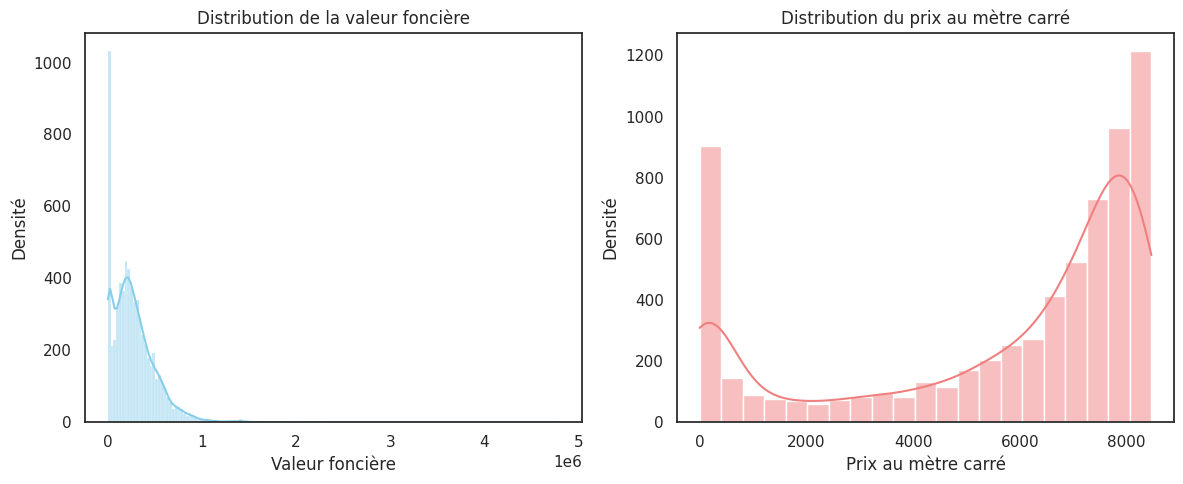

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tracer l'histogramme pour la colonne "valeur_fonciere"
sns.histplot(df_paris['valeur_fonciere'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution de la valeur foncière')
axes[0].set_xlabel('Valeur foncière')
axes[0].set_ylabel('Densité')

# Tracer l'histogramme pour la colonne "prix_au_metre_carre"
sns.histplot(df_paris['prix_au_metre_carre'], kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution du prix au mètre carré')
axes[1].set_xlabel('Prix au mètre carré')
axes[1].set_ylabel('Densité')

# Ajuster la disposition des graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

In [ ]:
(df_paris['valeur_fonciere'] <= 1500000).mean() * 100

99.82000899955003

On s'aperçoit qu'il y a une forte proportion de biens qui ont une valeur foncière et un prix au mètre carré très faible. Nous nous apercevons rapidement qu'il y a un problème de prix symbolique ou de don. Nous allons le retirer de notre dataset pour faire notre modèle, car ces lignes sont des outliers. Nous retirons les valeurs foncières en dessous de 30000€ et les prix au mètre carré inférieurs à 1000€. On remarque aussi que 99.8% des biens ont une valeur foncière inférieure à 1 500 000€ donc on décide d'éliminer les valeurs plus hautes.

In [ ]:
modele1 = df_paris[(df_paris['prix_au_metre_carre'] > 1000) & (df_paris['valeur_fonciere'] > 30000) & (df_paris['valeur_fonciere'] <= 1500000)].copy()

In [ ]:
modele1.shape[0]

5495

On tombe à 5495 données, et on retrace les distributions, qui sont maintenant sans outlier.

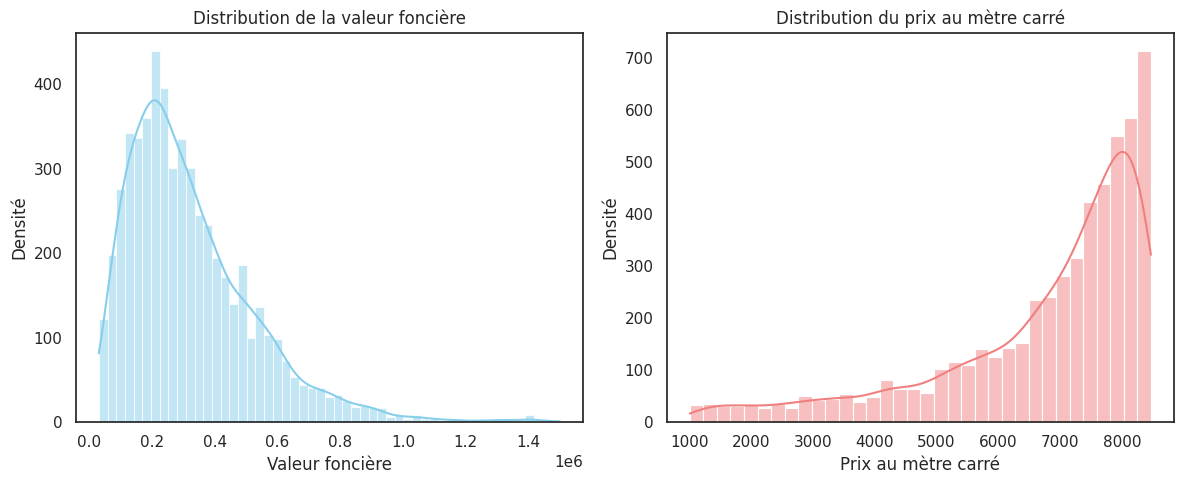

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tracer l'histogramme pour la colonne "valeur_fonciere"
sns.histplot(modele1['valeur_fonciere'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution de la valeur foncière')
axes[0].set_xlabel('Valeur foncière')
axes[0].set_ylabel('Densité')

# Tracer l'histogramme pour la colonne "prix_au_metre_carre"
sns.histplot(modele1['prix_au_metre_carre'], kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution du prix au mètre carré')
axes[1].set_xlabel('Prix au mètre carré')
axes[1].set_ylabel('Densité')

# Ajuster la disposition des graphiques
plt.tight_layout()

# Afficher

On a un pic un peu plus grand, il correspond à 200 000€ et est dû au fait que beaucoup de personnes vendent leur bien à ce prix.

In [ ]:
modele1['valeur_fonciere'].mean()

323218.2456141947

Le prix moyen d'un bien est d'environ 323 000€.

In [ ]:
list(df_paris.columns)

['id_mutation',
 'date_mutation',
 'nature_mutation',
 'valeur_fonciere',
 'adresse_nom_voie',
 'code_commune',
 'nom_commune',
 'code_departement',
 'nombre_lots',
 'type_local',
 'surface_reelle_bati',
 'nombre_pieces_principales',
 'longitude',
 'latitude',
 'prix_au_metre_carre',
 'arrondissement',
 'nom_station',
 'distance_station_plus_proche',
 'nom_ev',
 'distance_parc_plus_proche',
 'note',
 'prix_moy_m2_arr',
 'mois_vente',
 'indicatrice_maison',
 'type_voie',
 'voie_num',
 'arrondissement_01',
 'arrondissement_02',
 'arrondissement_03',
 'arrondissement_04',
 'arrondissement_05',
 'arrondissement_06',
 'arrondissement_07',
 'arrondissement_08',
 'arrondissement_09',
 'arrondissement_10',
 'arrondissement_11',
 'arrondissement_12',
 'arrondissement_13',
 'arrondissement_14',
 'arrondissement_15',
 'arrondissement_16',
 'arrondissement_17',
 'arrondissement_18',
 'arrondissement_19',
 'arrondissement_20',
 'annonces_arrondissement']

In [ ]:
colonnes_a_conserver = ['valeur_fonciere',
 'nombre_lots',
 'surface_reelle_bati',
 'nombre_pieces_principales',
 'longitude',
 'latitude',
 'prix_au_metre_carre',
 'distance_station_plus_proche',
 'distance_parc_plus_proche',
 'note',
 'prix_moy_m2_arr',
 'indicatrice_maison',
 'voie_num',
 'arrondissement_01',
 'arrondissement_02',
 'arrondissement_03',
 'arrondissement_04',
 'arrondissement_05',
 'arrondissement_06',
 'arrondissement_07',
 'arrondissement_08',
 'arrondissement_09',
 'arrondissement_10',
 'arrondissement_11',
 'arrondissement_12',
 'arrondissement_13',
 'arrondissement_14',
 'arrondissement_15',
 'arrondissement_16',
 'arrondissement_17',
 'arrondissement_18',
 'arrondissement_19',
 'arrondissement_20',
 'annonces_arrondissement']

On prépare nos vecteurs X et y avec les variables explicatives et la variable expliquée, qui est ici la valeur foncière.

On va ensuite sélectionner les colonnes dont on se servira pour nos régressions. On retire aussi valeur_fonciere des variables explicatives.

In [ ]:
X = modele1.copy()
X = X[colonnes_a_conserver]
y = X['valeur_fonciere']
X = X.drop('valeur_fonciere', axis=1)

On subdivise la base de données en trois parties : le set d'entraînement (utilisé pour ajuster le modèle), le set de test (pour évaluer les performances), et le set de validation. On prend 20% des données pour l'ensemble de test, et 80% pour l'entrainement, puis 25% de l'entrainement pour la validation.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=2)
print(f' X_train shape : {X_train.shape}')
print(f' X_val shape : {X_val.shape}')
print(f' X_test shape : {X_test.shape}')

 X_train shape : (3297, 33)
 X_val shape : (1099, 33)
 X_test shape : (1099, 33)


## 6.3 Méthode des moindres carrés (OLS)

On opère la régression par OLS sur X_train.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std = StandardScaler()
std.fit(X_train.values)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     756.5
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:26:12   Log-Likelihood:                -41667.
No. Observations:                3297   AIC:                         8.339e+04
Df Residuals:                    3267   BIC:                         8.358e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         3.247e+05   1303.880    249.052      0.000    3.22e+05    3.27e+05
nombre_lots                   7459.5610   1344.739      5.547      0.000    4822.945    1.01e+04
surface_reelle_bati           1.532e+05   2525.162     60.653      0.000    1.48e+05    1.58e+05
nombre_pieces_principales     3.368e+04   2509.433     13.420      0.000    2.88e+04    3.86e+04
longitude                    -9556.6761   5235.977     -1.825      0.068   -1.98e+04     709.453
latitude                       314.8901   5017.129      0.063      0.950   -9522.146    1.02e+04
prix_au_metre_carre           9.935e+04   1359.690     73.068      0.000    9.67e+04    1.02e+05
distance_station_plus_proche -1636.7553   1374.667     -1.191      0.234   -4332.052    1058.542
distance_parc_plus_proche      394.9358   1398.241      0.282      0.778   -2346.581    3136.452
note                          -284.6474   1208.695     -0.235      0.814   -2654.525    2085.230
prix_moy_m2_arr              -3080.6041   1338.635     -2.301      0.021   -5705.253    -455.955
indicatrice_maison            2097.8266   1322.416      1.586      0.113    -495.022    4690.675
voie_num                      2202.9024   1362.032      1.617      0.106    -467.621    4873.426
arrondissement_01             1276.3996   1299.244      0.982      0.326   -1271.015    3823.814
arrondissement_02              923.2992   1290.609      0.715      0.474   -1607.185    3453.783
arrondissement_03             2700.1422   1381.003      1.955      0.051      -7.577    5407.862
arrondissement_04               -8.7544   1296.293     -0.007      0.995   -2550.384    2532.875
arrondissement_05             -429.6986   1302.149     -0.330      0.741   -2982.809    2123.412
arrondissement_06             1098.4104   1246.296      0.881      0.378   -1345.190    3542.010
arrondissement_07            -1699.6728   1212.537     -1.402      0.161   -4077.082     677.737
arrondissement_08             -630.4037   1384.633     -0.455      0.649   -3345.240    2084.433
arrondissement_09            -1773.6652   1470.170     -1.206      0.228   -4656.213    1108.883
arrondissement_10             1420.0749   1165.594      1.218      0.223    -865.294    3705.443
arrondissement_11             -545.3062   1633.240     -0.334      0.738   -3747.584    2656.971
arrondissement_12             3253.8970   1948.657      1.670      0.095    -566.815    7074.609
arrondissement_13               57.6258   2332.772      0.025      0.980   -4516.218    4631.469
arrondissement_14            -1057.5959   2090.138     -0.506      0.613   -5155.709    3040.517
arrondissement_15            -2673.9336   2735.318     -0.978      0.328   -8037.045    2689.178
arrondissement_16            -3153.3742   2309.562     -1.365      0.172   -

On remarque plusieurs choses : le R² est de 0.87, ce qui suggère que les variables explicatives permettent plutôt bien de décrire les valeurs foncières. On remarque que nous avons certaines p-values à 0.000 ou très faibles, et donc une très forte significativité de celles-ci. Cependant, nous avons également des variables beaucoup moins significatives, comme la latitude, la distance à l'espaces vert le plus proche, ou encore la note de l'arrondissement. On remarque également, que contrairement à la latitude, la longitude est assez significative. Cela s'explique par le fait que les arrondissements les plus chers se situent plutot dans l'ouest parisien, et que le sud ou le nord n'impactent peu. De plus, on remarque que l'indicatrice des arrondissements est très significative dans certains, comme le 18e ou le 20e, mais pas du tout dans le 13e ou le 4e. On remarque aussi que les coefficients les plus grands sont la surface réelle du bien, le nombre de pièces et le prix au mètre carré, ce qui est cohérent. Le coefficient de la distance à la station la plus proche est négatif et de -1636, ce qui signifie qu'en moyenne, pour chaque unité d'augmentation de la distance à la station de métro la plus proche, la valeur du bien immobilier diminue de 1636€, toutes choses égales par ailleurs, ce qui est cohérent, car avoir des transports accessibles est un avantage. En revanche, le coefficient de la distance à l'espace vert le plus proche est positif, ce qui signifie que plus on est loin d'un espace vert, plus le bien est cher. Cela parait incohérent, mais comme la p-valeur est de 0.778, ce coefficient n'est pas significatif.

## 6.4 Régression avec Scikit-Learn

On commence par définir l'erreur absolue moyenne entre les valeurs réelles et les valeurs prédites. Cette métrique permet d'évaluer la précision du modèle, et plus elle se rapproche de zéro, plus le modèle est précis. Il est important de noter que cette mesure est exprimée dans la même unité que les valeurs du modèle. Par conséquent, pour évaluer précisément la précision, il est recommandé de la comparer aux valeurs réelles, notamment aux prix dans ce contexte.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
def ema_score(pred, actual):
    return np.mean(np.abs(np.exp(actual) - np.exp(pred)))

In [ ]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

train_pred = lr.predict(X_train_scaled)
val_pred = lr.predict(X_val_scaled)

print(f'Linear Regression (train) R^2: {lr.score(X_train_scaled, y_train)}')
print(f'Linear Regression (validation) R^2: {lr.score(X_val_scaled, y_val)}')

print("\n EMA du Train:", round(mean_absolute_error(y_train, train_pred),4))
print("EMA de Validation:", round(mean_absolute_error(y_val, val_pred),4))

Linear Regression (train) R^2: 0.8703865035052486
Linear Regression (validation) R^2: 0.8745852689684499

 EMA du Train: 46805.7375
EMA de Validation: 46533.6158


On constate que les R² sont de 0.87 comme dans l'autre régression. L'erreur moyenne absolue est d'environ 46000€, ce qui est une erreur correcte comparée à la valeur foncière moyenne calculée plus haut. On peut alors dire que le modèle est d'une précision correcte.

Traçons maintenant les valeurs foncières réelles comparées à celles prédites.

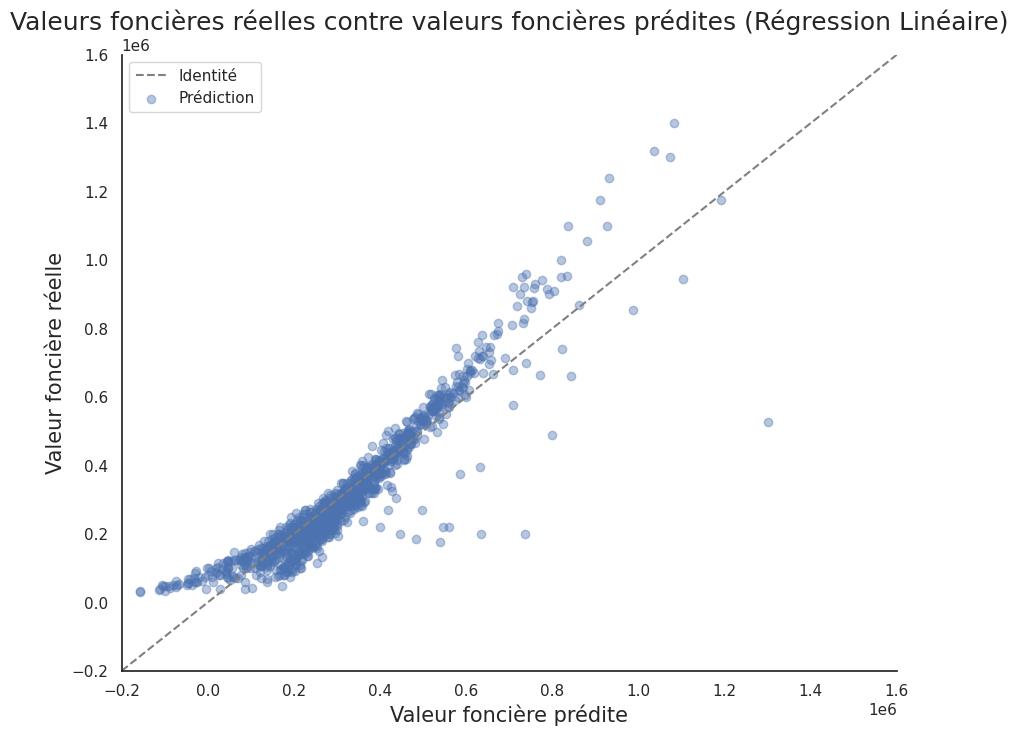

In [ ]:
plt.figure(figsize=(10, 8))

plt.xlim(-2e5, 1.6e6)
plt.ylim(-2e5, 1.6e6)
plt.plot([-2e5, 1.6e6], [-2e5, 1.6e6], label='Identité', linestyle='--', color='gray')

plt.scatter(val_pred, y_val, alpha=0.4, label='Prédiction')

sns.despine()

plt.ylabel('Valeur foncière réelle', size=15)
plt.xlabel('Valeur foncière prédite', size=15)
plt.title('Valeurs foncières réelles contre valeurs foncières prédites (Régression Linéaire)', size=18)

plt.legend()

plt.savefig('actual_plot', bbox_inches='tight', dpi=400)
plt.show()

Les prédictions sont assez proches de la fonction identité, ce qui est cohérent avec le R² de 0.87. Cependant, on observe que le modèle est très satisfaisant pour les prix entre 50 000€ et 600 000€, mais qu'au delà, il y a une dispersion, avec une valeur foncière prédite plus faible que la valeur foncière réelle.

Traçons maintenant la distribution des résidus.

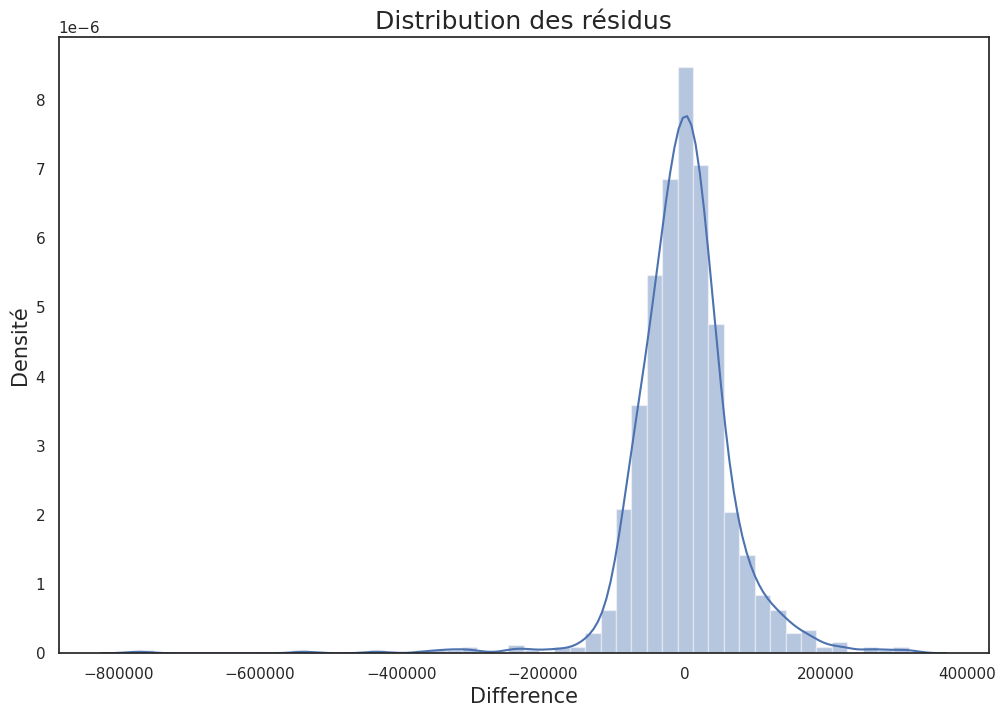

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(y_val - val_pred)
plt.title('Distribution des résidus', size = 18)
plt.xlabel('Difference', size = 15);
plt.ylabel('Densité', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

Les résidus sont distribués selon une loi normale centrée en 0, ce qui est cohérent avec l'hypothèse habituelle de normalité des erreurs.

## 6.5 Importance de chaque coefficient

In [ ]:
X_train.columns

Index(['nombre_lots', 'surface_reelle_bati', 'nombre_pieces_principales',
       'longitude', 'latitude', 'prix_au_metre_carre',
       'distance_station_plus_proche', 'distance_parc_plus_proche', 'note',
       'prix_moy_m2_arr', 'indicatrice_maison', 'voie_num',
       'arrondissement_01', 'arrondissement_02', 'arrondissement_03',
       'arrondissement_04', 'arrondissement_05', 'arrondissement_06',
       'arrondissement_07', 'arrondissement_08', 'arrondissement_09',
       'arrondissement_10', 'arrondissement_11', 'arrondissement_12',
       'arrondissement_13', 'arrondissement_14', 'arrondissement_15',
       'arrondissement_16', 'arrondissement_17', 'arrondissement_18',
       'arrondissement_19', 'arrondissement_20', 'annonces_arrondissement'],
      dtype='object')